In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
dataroot = "/kaggle/input/celebahq-resized-256x256"

In [5]:
image_size = 128
batchsize   = 128

The dataset

In [6]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                           ]))

In [7]:
len(dataset)

30000

In [8]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                         shuffle=True,drop_last=True)

In [9]:
for x,y in data_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 3, 128, 128])
torch.Size([128])


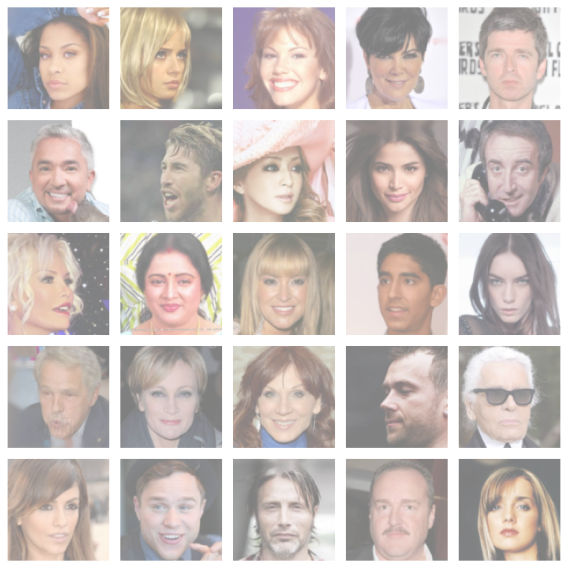

In [10]:
X,y = next(iter(data_loader))
fig,axs = plt.subplots(5,5,figsize=(8,8))
for (i,ax) in enumerate(axs.flatten()):

  
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 
  label = dataset.classes[y[i]]
 
  ax.imshow(pic)
  ax.axis('off')

plt.tight_layout()
plt.show()

# The Model 

In [11]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()
        self.latent_dim = 250
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.z_mean = nn.Linear(512*8*8, self.latent_dim)
        self.z_log = nn.Linear(512*8*8, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, input):
        bs = input.shape[0]

        x = self.relu(self.conv1(input))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        z_mean = self.z_mean(x)
        z_log = self.z_log(x)

        eps = torch.randn(bs, self.latent_dim, device=input.device)
        z_val = z_mean + torch.exp(z_log / 2) * eps
        return z_mean, z_log, z_val
    


class VAEDecoder(nn.Module):
    def __init__(self):
        super(VAEDecoder, self).__init__()
        self.latent_dim = 250
        self.fc1 = nn.Linear(self.latent_dim, 512*8*8)
        self.reshape = nn.Unflatten(1, (512, 8, 8))
        self.conv1 = nn.ConvTranspose2d(512, 256, 3, stride=2)
        self.conv2 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, 3, 2, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, input):
        x = self.relu(self.fc1(input))
        x = self.reshape(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        decoded = self.sigmoid(self.conv4(x))
        return decoded
    



class VAEAutoEncoder(nn.Module):
        
    def __init__(self):
        super(VAEAutoEncoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def forward(self, input):
        z_mean, z_log, z_val = self.encoder(input)
        decoded = self.decoder(z_val)
        return decoded, z_mean, z_log, z_val

In [12]:
model = VAEAutoEncoder()

if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

using 2 GPUs


DataParallel(
  (module): VAEAutoEncoder(
    (encoder): VAEEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (z_mean): Linear(in_features=32768, out_features=250, bias=True)
      (z_log): Linear(in_features=32768, out_features=250, bias=True)
      (relu): ReLU()
    )
    (decoder): VAEDecoder(
      (fc1): Linear(in_features=250, out_features=32768, bias=True)
      (reshape): Unflatten(dim=1, unflattened_size=(512, 8, 8))
      (conv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3)

Loss function

In [13]:
def vae_loss(preds, targets, z_mean, z_log_var, z_val):
    reconstruction_loss = F.mse_loss(preds, targets, reduction='sum') / preds.size(0)
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    kl_divergence /= preds.size(0)  
    return reconstruction_loss + kl_divergence

In [14]:
lr = 1e-3
eps = 1e-8
epochs = 50

In [15]:
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

Training 

In [16]:
def train_vae(train_dataloader, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    epoch_train_losses = []

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch  
            imgs = imgs.to(device)

            optimizer.zero_grad()

            preds,z_mean, z_log, z_val = model(imgs)
            #print(preds.shape)
            #print(z_val.shape)
            loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()


        train_loss /= len(train_dataloader)
        
        epoch_train_losses.append(train_loss)

        tqdm_dct = {'train loss': train_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()
        
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, epochs + 1), epoch_train_losses, label='Train Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 50/50 [1:19:15<00:00, 95.11s/it, train loss=426]    


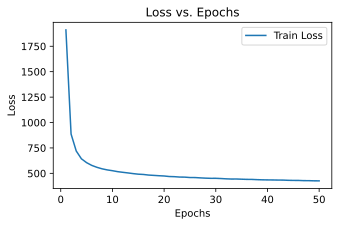

In [17]:
train_vae(data_loader, model, optimizer, epochs, device)

Reconstruction of images

In [18]:
def plot_images(n, images):
    fig, ax = plt.subplots(1, n, figsize=(12, 3)) 
    for i in range(n):

        if isinstance(images[i], tuple):
            image = images[i][0]
        else:
            image = images[i]

        image = image.permute(1, 2, 0).numpy()
        ax[i].imshow(image)
        ax[i].axis('off')
    plt.show()

torch.Size([1, 3, 128, 128])
torch.Size([1, 250])
torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 250])
torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 250])
torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 250])
torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 250])
torch.Size([3, 128, 128])


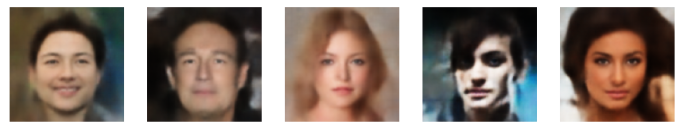

In [19]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(dataset):
    if i == plots:
        break
        
    output_imgs = model(data[0].to(device).unsqueeze(0))
    print(output_imgs[0].shape)
    print(output_imgs[3].shape)
    op_img = output_imgs[0].view(3, 128, 128)
    print(op_img.shape)
    predictions.append(op_img.detach().cpu())
plot_images(plots, predictions)

# Sampling from the latent space and plotting the images

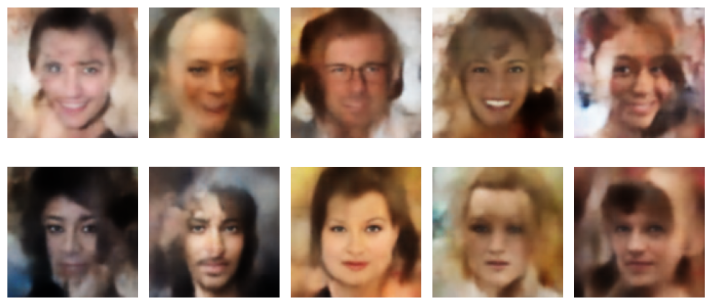

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))  
for i in range(10):
    rand = torch.randn(1, 250).to(device)
    chek = model.module.decoder(rand)
    chek = chek.view(3, 128, 128)
    chek = chek.detach().cpu()
    
    row = i // 5  
    col = i % 5   
    img = chek.permute(1, 2, 0).numpy()
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
plt.tight_layout()
plt.savefig('/kaggle/working/output_imgs.png') 
plt.show()